Decision Tree accuracy: 89.09%


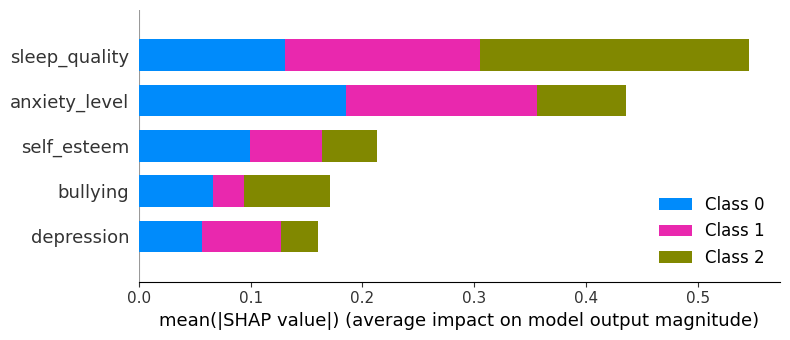

Explicación de LIME guardada como Decision Tree_lime_explanation.html.


/home/reboot-student/STRESSFACTOR/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Random Forest accuracy: 90.00%


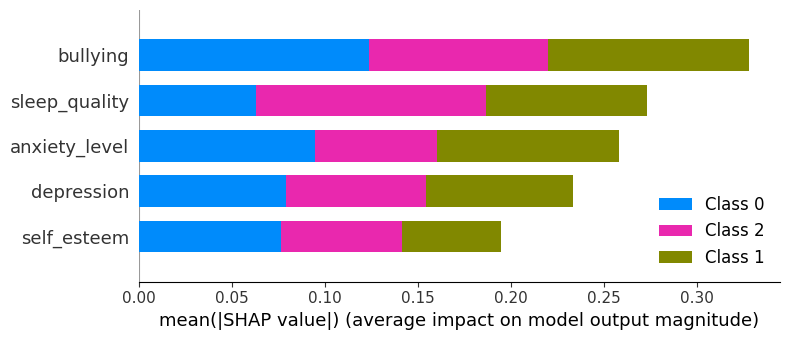

/home/reboot-student/STRESSFACTOR/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
Using 880 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Explicación de LIME guardada como Random Forest_lime_explanation.html.
SVM accuracy: 90.00%


  0%|          | 0/220 [00:00<?, ?it/s]

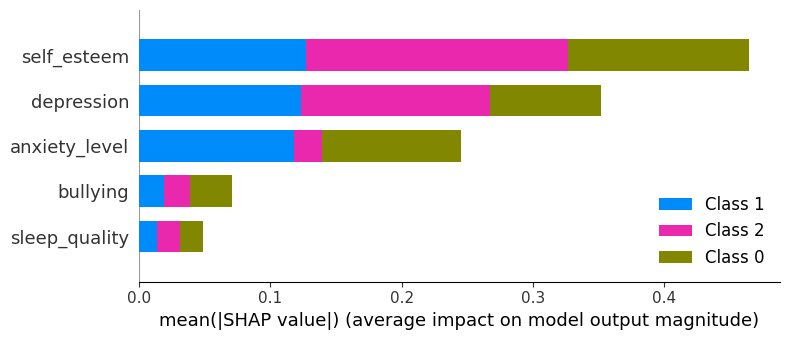

/home/reboot-student/STRESSFACTOR/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Explicación de LIME guardada como SVM_lime_explanation.html.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import shap
from lime.lime_tabular import LimeTabularExplainer
import xgboost as xgb
import lightgbm as lgb
import joblib

# Cargar datos y definir variables
df = pd.read_csv('../data/ReBoot_Student_Stress_Factors.csv')
X = df[['anxiety_level', 'self_esteem', 'depression', 'sleep_quality', 'bullying']]
y = df['stress_level']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos iniciales
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)  # Asegúrate de que SVM tenga probability=True
}

# Entrenamiento y evaluación
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} accuracy: {accuracy * 100:.2f}%')

    # Explicabilidad con SHAP
    if name in ["Decision Tree", "Random Forest"]:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Si el modelo es multiclase, shap_values será una lista con la cantidad de clases
        if isinstance(shap_values, list):
            # Iterar sobre cada clase
            for i in range(len(shap_values)):
                print(f"Visualizando para clase {i}")
                shap.summary_plot(shap_values[i], X_test, plot_type="bar", class_names=["Low", "Medium", "High"])
        else:
            # Para clasificación binaria o única clase
            shap.summary_plot(shap_values, X_test, plot_type="bar")
    elif name == "SVM":
        # Para SVM, usamos KernelExplainer de SHAP
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")

    # Explicabilidad con LIME
    explainer_lime = LimeTabularExplainer(
        training_data=X_train.values,
        training_labels=y_train.values,
        mode="classification",
        feature_names=X_train.columns,
        class_names=["Low", "Medium", "High"],
        discretize_continuous=True
    )
    instance = X_test.iloc[0].values.reshape(1, -1)
    explanation = explainer_lime.explain_instance(instance[0], model.predict_proba)
    explanation.save_to_file(f"{name}_lime_explanation.html")
    print(f"Explicación de LIME guardada como {name}_lime_explanation.html.")

# Modelos adicionales con optimización
models.update({
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier()
})

# Parámetros para optimizar para XGBoost y LightGBM
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],  # Añadir más parámetros
    'colsample_bytree': [0.8, 1.0]
}
# Crear GridSearchCV para XGBoost y LightGBM
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5)
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(), param_grid, cv=5)

# Entrenar y optimizar
grid_search_xgb.fit(X_train, y_train)
print(f'Best XGBoost parameters: {grid_search_xgb.best_params_}')

grid_search_lgb.fit(X_train, y_train)
print(f'Best LightGBM parameters: {grid_search_lgb.best_params_}')

# SHAP para XGBoost y LightGBM
explainer_xgb = shap.TreeExplainer(grid_search_xgb.best_estimator_)
explainer_lgb = shap.TreeExplainer(grid_search_lgb.best_estimator_)

# Visualización de SHAP para XGBoost
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test)

# Visualización de SHAP para LightGBM
shap_values_lgb = explainer_lgb.shap_values(X_test)
shap.summary_plot(shap_values_lgb, X_test)

# Guardar los modelos entrenados en una carpeta "models"
joblib.dump(grid_search_xgb.best_estimator_, 'models/best_xgb_model.pkl')
joblib.dump(grid_search_lgb.best_estimator_, 'models/best_lgb_model.pkl')

print("Modelos optimizados guardados como 'models/best_xgb_model.pkl' y 'models/best_lgb_model.pkl'.")
